## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
import os
import pickle
import time
from tqdm import tqdm_notebook
from collections import deque
from replay_memory import ReplayBuffer, PrioritizedReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv

## 하이퍼 파라미터 정의하기

In [2]:
'''SAC Settings'''
# coefficient of entropy regularization
ENT_COEF = 1e-2
# experience replay memory size
MEMORY_CAPACITY = 10**6
# learn start
LEARN_START = int(1e+3)
# learn frequency
LEARN_FREQ = 1

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
# number of environments for SAC
N_ENVS = 4
# define gym 
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  4
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = 10**7
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 32
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1

'''Save&Load Settings'''
# log frequency
LOG_FREQ = int(1e+3)
# check save/load
SAVE = True
LOAD = False
# paths for predction net, target net, result log
ACTOR_PATH = './data/model/actor_net.pkl'
CRITIC_PATH = './data/model/critic_net.pkl'
ACTION_CRITIC_PATH = './data/model/action_critic_net.pkl'

/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Plea

N_ACTIONS :  4
N_STATES :  (4, 84, 84)
USE GPU: True


/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 네트워크 구조 정의하기

In [3]:
class ActorConvNet(nn.Module):
    def __init__(self):
        super(ActorConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.actor = nn.Linear(256, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(x), dim=1)

        return action_log_prob

    def save(self, PATH):
        torch.save(self.state_dict(),ACTOR_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(ACTOR_PATH))
        
class CriticConvNet(nn.Module):
    def __init__(self):
        super(CriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.critic = nn.Linear(256, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        value = self.critic(x)

        return value

    def save(self, PATH):
        torch.save(self.state_dict(),CRITIC_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(CRITIC_PATH))
        
class ActionCriticConvNet(nn.Module):
    def __init__(self):
        super(ActionCriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.action_critic = nn.Linear(256, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_value = self.action_critic(x)

        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),ACTION_CRITIC_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(ACTION_CRITIC_PATH))

## SAC 정의하기

In [4]:
class SAC:
    def __init__(self):
        self.actor_net = ActorConvNet()
        self.critic_net = CriticConvNet()
        self.critic_target = CriticConvNet()
        self.action_critic_net = ActionCriticConvNet()
        # use gpu
        if USE_GPU:
            self.actor_net = self.actor_net.cuda(device=3)
            self.critic_net = self.critic_net.cuda(device=3)
            # critic target network for stability
            self.critic_target = self.critic_net.cuda(device=3)
            self.action_critic_net = self.action_critic_net.cuda(device=3)
        
        # sync net and target
        self.critic_target.load_state_dict(self.critic_net.state_dict())
            
        # simulator step conter
        self.memory_counter = 0
        self.learn_step_counter = 0
        
        # Create the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
            
        # define optimizer
        self.actor_opt = torch.optim.Adam(self.actor_net.parameters(), lr=LR)
        self.critic_opt = torch.optim.Adam(self.critic_net.parameters(), lr=LR)
        self.action_critic_opt = torch.optim.Adam(self.action_critic_net.parameters(), lr=LR)
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
        
    def save_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.action_critic_net.cpu()
        
        self.actor_net.save(ACTOR_PATH)
        self.critic_net.save(CRITIC_PATH)
        self.action_critic_net.save(ACTION_CRITIC_PATH)
        
        if USE_GPU:
            self.actor_net.cuda(device=3)
            self.critic_net.cuda(device=3)
            self.action_critic_net.cuda(device=3)
            
    def load_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.action_critic_net.cpu()
        
        self.actor_net.load(ACTOR_PATH)
        self.critic_net.load(CRITIC_PATH)
        self.action_critic_net.load(ACTION_CRITIC_PATH)
        
        if USE_GPU:
            self.actor_net.cuda(device=3)
            self.critic_net.cuda(device=3)
            self.action_critic_net.cuda(device=3)
        
    def choose_action(self, x):
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda(device=3)
        # get action log probs and state values
        action_log_prob = self.actor_net(x)
        action_prob = F.softmax(action_log_prob, dim=1).data.cpu().numpy()
        # sample actions
        action = np.array([np.random.choice(N_ACTIONS,p=action_prob[i]) for i in range(len(action_prob))])
        return action
    
    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))

    def learn(self):
        self.learn_step_counter += 1
        
        # data sample from experience replay
        b_state_memory, b_action_memory, b_reward_memory, \
        b_next_state_memory, b_done = self.replay_buffer.sample(BATCH_SIZE)
        b_weights, b_idxes = np.ones_like(b_reward_memory), None
            
        b_s = torch.FloatTensor(b_state_memory)
        b_a = torch.LongTensor(b_action_memory)
        b_r = torch.FloatTensor(b_reward_memory)
        b_s_ = torch.FloatTensor(b_next_state_memory)
        b_d = torch.FloatTensor(b_done)

        if USE_GPU:
            b_s, b_a, b_r, b_s_, b_d = b_s.cuda(device=3), b_a.cuda(device=3), b_r.cuda(device=3), b_s_.cuda(device=3), b_d.cuda(device=3)
            
        # forward calc
        action_log_prob = self.actor_net(b_s)
        action_prob = F.softmax(action_log_prob, dim=1)
        action_log_prob = F.log_softmax(action_log_prob, dim=1)
        cur_value = self.critic_net(b_s).squeeze(1)
        next_value = self.critic_target(b_s_)
        action_value = self.action_critic_net(b_s)

        # critic loss. eq (5) in SAC paper
        value_target = (action_value - ENT_COEF * action_log_prob).gather(1, b_a.unsqueeze(1)).squeeze(1)
        critic_loss = 0.5 * F.smooth_l1_loss(cur_value, value_target.detach())

        # action critic loss. eq (7), (8) in SAC paper
        action_value_target = b_r + GAMMA * (1-b_d) * next_value.squeeze(1)
        action_critic_loss = 0.5 * F.smooth_l1_loss(action_value.gather(1, 
            b_a.unsqueeze(1)).squeeze(1), action_value_target.detach())

        # actor loss. eq (10) in SAC paper
        actor_loss = torch.mean(action_prob*(action_log_prob \
            - F.log_softmax(action_value.detach()/ENT_COEF, dim=1)))

        self.actor_opt.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor_net.parameters(), MAX_GRAD_NORM)
        self.actor_opt.step()
        
        self.critic_opt.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic_net.parameters(), MAX_GRAD_NORM)
        self.critic_opt.step()
        
        self.action_critic_opt.zero_grad()
        action_critic_loss.backward()
        nn.utils.clip_grad_norm_(self.action_critic_net.parameters(), MAX_GRAD_NORM)
        self.action_critic_opt.step()
        
        self.update_target(self.critic_target, self.critic_net, 1e-3)
        
        return round(float(actor_loss), 4), round(float(critic_loss), 4), round(float(action_critic_loss), 4)

## 학습

In [5]:
sac = SAC()

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    sac.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# check learning time
start_time = time.time()

# env reset
s = np.array(env.reset())

for step in tqdm_notebook(range(1, N_STEP//N_ENVS + 1)):
    
    a = sac.choose_action(s)
    
    # take action and get next state
    s_, r, done, infos = env.step(a)
    s_ = np.array(s_)
    
    # log arrange
    for info in infos:
        maybeepinfo = info.get('episode')
        if maybeepinfo: epinfobuf.append(maybeepinfo)
            
    # store transition
    for i in range(len(s_)):
        sac.store_transition(s[i],a[i],r[i],s_[i], done[i])
        
    if (step >= LEARN_START) and (step % LEARN_FREQ == 0):
        sac.learn()
        
    s = s_
            
    if step % LOG_FREQ == 0:
        # print log and save
        # check time interval
        time_interval = round(time.time() - start_time, 2)
        # calc mean return
        mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
        result.append(mean_100_ep_return)
        # print epi log
        print('Used Step:',sac.memory_counter,
              '| Mean ep 100 return: ', mean_100_ep_return,
              '| Used Time:',time_interval)
        # save model
        if SAVE:
            sac.save_model()

Initialize results!


Used Step: 4000 | Mean ep 100 return:  0.7 | Used Time: 8.16
Used Step: 8000 | Mean ep 100 return:  1.14 | Used Time: 47.66
Used Step: 12000 | Mean ep 100 return:  1.09 | Used Time: 88.74
Used Step: 16000 | Mean ep 100 return:  1.18 | Used Time: 130.6
Used Step: 20000 | Mean ep 100 return:  1.32 | Used Time: 168.92
Used Step: 24000 | Mean ep 100 return:  1.17 | Used Time: 207.83
Used Step: 28000 | Mean ep 100 return:  1.35 | Used Time: 243.14
Used Step: 32000 | Mean ep 100 return:  1.23 | Used Time: 281.05
Used Step: 36000 | Mean ep 100 return:  1.12 | Used Time: 317.06
Used Step: 40000 | Mean ep 100 return:  1.26 | Used Time: 350.65
Used Step: 44000 | Mean ep 100 return:  1.54 | Used Time: 385.87
Used Step: 48000 | Mean ep 100 return:  1.9 | Used Time: 421.36
Used Step: 52000 | Mean ep 100 return:  2.26 | Used Time: 454.17
Used Step: 56000 | Mean ep 100 return:  2.68 | Used Time: 488.02
Used Step: 60000 | Mean ep 100 return:  3.23 | Used Time: 520.95
Used Step: 64000 | Mean ep 100 ret

Used Step: 496000 | Mean ep 100 return:  33.2 | Used Time: 3958.91
Used Step: 500000 | Mean ep 100 return:  33.46 | Used Time: 3989.89
Used Step: 504000 | Mean ep 100 return:  33.67 | Used Time: 4021.02
Used Step: 508000 | Mean ep 100 return:  33.94 | Used Time: 4049.88
Used Step: 512000 | Mean ep 100 return:  34.36 | Used Time: 4079.42
Used Step: 516000 | Mean ep 100 return:  33.84 | Used Time: 4109.81
Used Step: 520000 | Mean ep 100 return:  33.64 | Used Time: 4140.43
Used Step: 524000 | Mean ep 100 return:  33.79 | Used Time: 4171.9
Used Step: 528000 | Mean ep 100 return:  34.23 | Used Time: 4202.68
Used Step: 532000 | Mean ep 100 return:  34.16 | Used Time: 4234.28
Used Step: 536000 | Mean ep 100 return:  34.5 | Used Time: 4266.86
Used Step: 540000 | Mean ep 100 return:  34.66 | Used Time: 4297.22
Used Step: 544000 | Mean ep 100 return:  35.42 | Used Time: 4328.28
Used Step: 548000 | Mean ep 100 return:  35.37 | Used Time: 4359.32
Used Step: 552000 | Mean ep 100 return:  36.15 | Us

Used Step: 980000 | Mean ep 100 return:  59.3 | Used Time: 7734.36
Used Step: 984000 | Mean ep 100 return:  60.46 | Used Time: 7764.64
Used Step: 988000 | Mean ep 100 return:  59.89 | Used Time: 7796.0
Used Step: 992000 | Mean ep 100 return:  60.5 | Used Time: 7828.05
Used Step: 996000 | Mean ep 100 return:  60.65 | Used Time: 7859.36
Used Step: 1000000 | Mean ep 100 return:  61.45 | Used Time: 7890.28
Used Step: 1004000 | Mean ep 100 return:  61.73 | Used Time: 7920.72
Used Step: 1008000 | Mean ep 100 return:  61.73 | Used Time: 7951.3
Used Step: 1012000 | Mean ep 100 return:  62.32 | Used Time: 7982.16
Used Step: 1016000 | Mean ep 100 return:  61.68 | Used Time: 8013.64
Used Step: 1020000 | Mean ep 100 return:  61.76 | Used Time: 8044.83
Used Step: 1024000 | Mean ep 100 return:  62.07 | Used Time: 8077.06
Used Step: 1028000 | Mean ep 100 return:  62.59 | Used Time: 8108.31
Used Step: 1032000 | Mean ep 100 return:  62.8 | Used Time: 8140.38
Used Step: 1036000 | Mean ep 100 return:  62

Used Step: 1456000 | Mean ep 100 return:  76.02 | Used Time: 11465.22
Used Step: 1460000 | Mean ep 100 return:  75.42 | Used Time: 11496.17
Used Step: 1464000 | Mean ep 100 return:  74.49 | Used Time: 11526.49
Used Step: 1468000 | Mean ep 100 return:  74.56 | Used Time: 11557.2
Used Step: 1472000 | Mean ep 100 return:  74.45 | Used Time: 11587.98
Used Step: 1476000 | Mean ep 100 return:  73.57 | Used Time: 11618.88
Used Step: 1480000 | Mean ep 100 return:  72.85 | Used Time: 11649.99
Used Step: 1484000 | Mean ep 100 return:  73.26 | Used Time: 11681.66
Used Step: 1488000 | Mean ep 100 return:  73.44 | Used Time: 11712.7
Used Step: 1492000 | Mean ep 100 return:  73.81 | Used Time: 11742.96
Used Step: 1496000 | Mean ep 100 return:  74.31 | Used Time: 11773.73
Used Step: 1500000 | Mean ep 100 return:  75.47 | Used Time: 11804.92
Used Step: 1504000 | Mean ep 100 return:  75.64 | Used Time: 11835.1
Used Step: 1508000 | Mean ep 100 return:  74.49 | Used Time: 11867.01
Used Step: 1512000 | Me

Used Step: 1928000 | Mean ep 100 return:  79.48 | Used Time: 15148.06
Used Step: 1932000 | Mean ep 100 return:  79.89 | Used Time: 15177.48
Used Step: 1936000 | Mean ep 100 return:  81.01 | Used Time: 15205.68
Used Step: 1940000 | Mean ep 100 return:  80.82 | Used Time: 15233.71
Used Step: 1944000 | Mean ep 100 return:  80.39 | Used Time: 15261.76
Used Step: 1948000 | Mean ep 100 return:  80.75 | Used Time: 15291.24
Used Step: 1952000 | Mean ep 100 return:  81.86 | Used Time: 15319.7
Used Step: 1956000 | Mean ep 100 return:  81.32 | Used Time: 15347.89
Used Step: 1960000 | Mean ep 100 return:  80.94 | Used Time: 15375.82
Used Step: 1964000 | Mean ep 100 return:  80.09 | Used Time: 15404.1
Used Step: 1968000 | Mean ep 100 return:  78.13 | Used Time: 15433.68
Used Step: 1972000 | Mean ep 100 return:  77.42 | Used Time: 15463.49
Used Step: 1976000 | Mean ep 100 return:  77.59 | Used Time: 15494.31
Used Step: 1980000 | Mean ep 100 return:  79.51 | Used Time: 15525.02
Used Step: 1984000 | M

Used Step: 2400000 | Mean ep 100 return:  101.02 | Used Time: 18782.45
Used Step: 2404000 | Mean ep 100 return:  101.02 | Used Time: 18813.72
Used Step: 2408000 | Mean ep 100 return:  101.61 | Used Time: 18844.85
Used Step: 2412000 | Mean ep 100 return:  102.61 | Used Time: 18875.34
Used Step: 2416000 | Mean ep 100 return:  104.22 | Used Time: 18906.22
Used Step: 2420000 | Mean ep 100 return:  105.12 | Used Time: 18936.56
Used Step: 2424000 | Mean ep 100 return:  106.86 | Used Time: 18967.8
Used Step: 2428000 | Mean ep 100 return:  106.92 | Used Time: 18998.57
Used Step: 2432000 | Mean ep 100 return:  108.55 | Used Time: 19028.86
Used Step: 2436000 | Mean ep 100 return:  109.29 | Used Time: 19059.05
Used Step: 2440000 | Mean ep 100 return:  107.79 | Used Time: 19090.51
Used Step: 2444000 | Mean ep 100 return:  107.3 | Used Time: 19121.0
Used Step: 2448000 | Mean ep 100 return:  109.7 | Used Time: 19153.0
Used Step: 2452000 | Mean ep 100 return:  108.86 | Used Time: 19184.03
Used Step: 

Used Step: 2864000 | Mean ep 100 return:  107.56 | Used Time: 22417.43
Used Step: 2868000 | Mean ep 100 return:  109.54 | Used Time: 22449.7
Used Step: 2872000 | Mean ep 100 return:  106.47 | Used Time: 22481.32
Used Step: 2876000 | Mean ep 100 return:  105.34 | Used Time: 22512.66
Used Step: 2880000 | Mean ep 100 return:  106.06 | Used Time: 22544.88
Used Step: 2884000 | Mean ep 100 return:  105.83 | Used Time: 22575.88
Used Step: 2888000 | Mean ep 100 return:  106.97 | Used Time: 22608.49
Used Step: 2892000 | Mean ep 100 return:  104.55 | Used Time: 22639.96
Used Step: 2896000 | Mean ep 100 return:  105.3 | Used Time: 22671.25
Used Step: 2900000 | Mean ep 100 return:  105.09 | Used Time: 22702.47
Used Step: 2904000 | Mean ep 100 return:  103.82 | Used Time: 22734.04
Used Step: 2908000 | Mean ep 100 return:  103.1 | Used Time: 22765.19
Used Step: 2912000 | Mean ep 100 return:  102.28 | Used Time: 22796.4
Used Step: 2916000 | Mean ep 100 return:  101.98 | Used Time: 22827.52
Used Step:

Used Step: 3328000 | Mean ep 100 return:  162.33 | Used Time: 26042.98
Used Step: 3332000 | Mean ep 100 return:  161.88 | Used Time: 26073.96
Used Step: 3336000 | Mean ep 100 return:  160.06 | Used Time: 26105.63
Used Step: 3340000 | Mean ep 100 return:  161.66 | Used Time: 26136.44
Used Step: 3344000 | Mean ep 100 return:  161.11 | Used Time: 26168.14
Used Step: 3348000 | Mean ep 100 return:  160.84 | Used Time: 26199.53
Used Step: 3352000 | Mean ep 100 return:  160.09 | Used Time: 26230.37
Used Step: 3356000 | Mean ep 100 return:  160.78 | Used Time: 26262.25
Used Step: 3360000 | Mean ep 100 return:  161.41 | Used Time: 26292.86
Used Step: 3364000 | Mean ep 100 return:  163.06 | Used Time: 26325.97
Used Step: 3368000 | Mean ep 100 return:  165.21 | Used Time: 26357.88
Used Step: 3372000 | Mean ep 100 return:  163.13 | Used Time: 26389.57
Used Step: 3376000 | Mean ep 100 return:  165.16 | Used Time: 26422.11
Used Step: 3380000 | Mean ep 100 return:  166.78 | Used Time: 26453.73
Used S

Used Step: 3792000 | Mean ep 100 return:  225.52 | Used Time: 29666.23
Used Step: 3796000 | Mean ep 100 return:  227.03 | Used Time: 29697.59
Used Step: 3800000 | Mean ep 100 return:  226.04 | Used Time: 29729.82
Used Step: 3804000 | Mean ep 100 return:  225.69 | Used Time: 29761.16
Used Step: 3808000 | Mean ep 100 return:  226.28 | Used Time: 29792.96
Used Step: 3812000 | Mean ep 100 return:  226.87 | Used Time: 29824.13
Used Step: 3816000 | Mean ep 100 return:  225.81 | Used Time: 29856.32
Used Step: 3820000 | Mean ep 100 return:  225.35 | Used Time: 29887.14
Used Step: 3824000 | Mean ep 100 return:  225.21 | Used Time: 29918.0
Used Step: 3828000 | Mean ep 100 return:  225.31 | Used Time: 29948.54
Used Step: 3832000 | Mean ep 100 return:  228.63 | Used Time: 29978.9
Used Step: 3836000 | Mean ep 100 return:  230.66 | Used Time: 30011.18
Used Step: 3840000 | Mean ep 100 return:  234.32 | Used Time: 30042.37
Used Step: 3844000 | Mean ep 100 return:  236.13 | Used Time: 30074.01
Used Ste

Used Step: 4256000 | Mean ep 100 return:  281.75 | Used Time: 33284.58
Used Step: 4260000 | Mean ep 100 return:  286.6 | Used Time: 33315.36
Used Step: 4264000 | Mean ep 100 return:  286.77 | Used Time: 33346.07
Used Step: 4268000 | Mean ep 100 return:  284.46 | Used Time: 33377.15
Used Step: 4272000 | Mean ep 100 return:  287.88 | Used Time: 33409.46
Used Step: 4276000 | Mean ep 100 return:  287.41 | Used Time: 33440.01
Used Step: 4280000 | Mean ep 100 return:  286.77 | Used Time: 33468.59
Used Step: 4284000 | Mean ep 100 return:  289.67 | Used Time: 33496.67
Used Step: 4288000 | Mean ep 100 return:  291.32 | Used Time: 33524.79
Used Step: 4292000 | Mean ep 100 return:  291.31 | Used Time: 33553.28
Used Step: 4296000 | Mean ep 100 return:  291.58 | Used Time: 33581.23
Used Step: 4300000 | Mean ep 100 return:  293.8 | Used Time: 33610.75
Used Step: 4304000 | Mean ep 100 return:  295.64 | Used Time: 33640.86
Used Step: 4308000 | Mean ep 100 return:  296.26 | Used Time: 33671.46
Used Ste

Used Step: 4720000 | Mean ep 100 return:  343.26 | Used Time: 36874.96
Used Step: 4724000 | Mean ep 100 return:  343.92 | Used Time: 36906.01
Used Step: 4728000 | Mean ep 100 return:  344.72 | Used Time: 36936.77
Used Step: 4732000 | Mean ep 100 return:  344.13 | Used Time: 36967.87
Used Step: 4736000 | Mean ep 100 return:  343.82 | Used Time: 37000.04
Used Step: 4740000 | Mean ep 100 return:  345.52 | Used Time: 37030.8
Used Step: 4744000 | Mean ep 100 return:  345.93 | Used Time: 37062.1
Used Step: 4748000 | Mean ep 100 return:  344.46 | Used Time: 37093.78
Used Step: 4752000 | Mean ep 100 return:  343.83 | Used Time: 37125.03
Used Step: 4756000 | Mean ep 100 return:  344.67 | Used Time: 37155.68
Used Step: 4760000 | Mean ep 100 return:  346.11 | Used Time: 37187.05
Used Step: 4764000 | Mean ep 100 return:  345.8 | Used Time: 37218.94
Used Step: 4768000 | Mean ep 100 return:  346.77 | Used Time: 37249.61
Used Step: 4772000 | Mean ep 100 return:  347.59 | Used Time: 37282.01
Used Step

Used Step: 5184000 | Mean ep 100 return:  350.37 | Used Time: 40488.99
Used Step: 5188000 | Mean ep 100 return:  350.37 | Used Time: 40521.28
Used Step: 5192000 | Mean ep 100 return:  350.97 | Used Time: 40552.27
Used Step: 5196000 | Mean ep 100 return:  351.04 | Used Time: 40582.83
Used Step: 5200000 | Mean ep 100 return:  352.49 | Used Time: 40614.03
Used Step: 5204000 | Mean ep 100 return:  351.57 | Used Time: 40644.5
Used Step: 5208000 | Mean ep 100 return:  351.57 | Used Time: 40676.45
Used Step: 5212000 | Mean ep 100 return:  352.04 | Used Time: 40708.54
Used Step: 5216000 | Mean ep 100 return:  352.04 | Used Time: 40740.1
Used Step: 5220000 | Mean ep 100 return:  356.47 | Used Time: 40771.74
Used Step: 5224000 | Mean ep 100 return:  356.47 | Used Time: 40803.38
Used Step: 5228000 | Mean ep 100 return:  357.01 | Used Time: 40834.35
Used Step: 5232000 | Mean ep 100 return:  359.47 | Used Time: 40866.52
Used Step: 5236000 | Mean ep 100 return:  359.47 | Used Time: 40897.41
Used Ste

Used Step: 5648000 | Mean ep 100 return:  359.54 | Used Time: 44101.46
Used Step: 5652000 | Mean ep 100 return:  356.65 | Used Time: 44132.09
Used Step: 5656000 | Mean ep 100 return:  352.55 | Used Time: 44163.66
Used Step: 5660000 | Mean ep 100 return:  352.79 | Used Time: 44194.79
Used Step: 5664000 | Mean ep 100 return:  352.5 | Used Time: 44225.72
Used Step: 5668000 | Mean ep 100 return:  346.92 | Used Time: 44257.16
Used Step: 5672000 | Mean ep 100 return:  339.98 | Used Time: 44288.86
Used Step: 5676000 | Mean ep 100 return:  336.39 | Used Time: 44320.33
Used Step: 5680000 | Mean ep 100 return:  338.43 | Used Time: 44351.13
Used Step: 5684000 | Mean ep 100 return:  339.14 | Used Time: 44382.37
Used Step: 5688000 | Mean ep 100 return:  339.58 | Used Time: 44413.68
Used Step: 5692000 | Mean ep 100 return:  339.58 | Used Time: 44443.8
Used Step: 5696000 | Mean ep 100 return:  342.74 | Used Time: 44475.1
Used Step: 5700000 | Mean ep 100 return:  343.83 | Used Time: 44506.03
Used Step

Used Step: 6112000 | Mean ep 100 return:  367.28 | Used Time: 47686.71
Used Step: 6116000 | Mean ep 100 return:  368.15 | Used Time: 47717.24
Used Step: 6120000 | Mean ep 100 return:  368.15 | Used Time: 47747.26
Used Step: 6124000 | Mean ep 100 return:  368.15 | Used Time: 47777.21
Used Step: 6128000 | Mean ep 100 return:  368.55 | Used Time: 47807.54
Used Step: 6132000 | Mean ep 100 return:  368.5 | Used Time: 47838.55
Used Step: 6136000 | Mean ep 100 return:  368.0 | Used Time: 47871.04
Used Step: 6140000 | Mean ep 100 return:  367.88 | Used Time: 47902.15
Used Step: 6144000 | Mean ep 100 return:  368.42 | Used Time: 47932.91
Used Step: 6148000 | Mean ep 100 return:  368.55 | Used Time: 47964.61
Used Step: 6152000 | Mean ep 100 return:  367.69 | Used Time: 47995.1
Used Step: 6156000 | Mean ep 100 return:  366.7 | Used Time: 48025.88
Used Step: 6160000 | Mean ep 100 return:  366.31 | Used Time: 48056.67
Used Step: 6164000 | Mean ep 100 return:  367.38 | Used Time: 48087.22
Used Step:

Used Step: 6576000 | Mean ep 100 return:  361.48 | Used Time: 51284.67
Used Step: 6580000 | Mean ep 100 return:  361.48 | Used Time: 51316.66
Used Step: 6584000 | Mean ep 100 return:  360.94 | Used Time: 51348.0
Used Step: 6588000 | Mean ep 100 return:  361.1 | Used Time: 51379.46
Used Step: 6592000 | Mean ep 100 return:  363.92 | Used Time: 51411.52
Used Step: 6596000 | Mean ep 100 return:  363.95 | Used Time: 51442.67
Used Step: 6600000 | Mean ep 100 return:  364.81 | Used Time: 51473.83
Used Step: 6604000 | Mean ep 100 return:  364.84 | Used Time: 51504.42
Used Step: 6608000 | Mean ep 100 return:  366.14 | Used Time: 51535.41
Used Step: 6612000 | Mean ep 100 return:  366.73 | Used Time: 51565.87
Used Step: 6616000 | Mean ep 100 return:  366.39 | Used Time: 51596.23
Used Step: 6620000 | Mean ep 100 return:  366.3 | Used Time: 51626.89
Used Step: 6624000 | Mean ep 100 return:  363.79 | Used Time: 51658.99
Used Step: 6628000 | Mean ep 100 return:  363.43 | Used Time: 51690.63
Used Step

Used Step: 7040000 | Mean ep 100 return:  401.38 | Used Time: 54890.22
Used Step: 7044000 | Mean ep 100 return:  401.38 | Used Time: 54921.09
Used Step: 7048000 | Mean ep 100 return:  402.12 | Used Time: 54952.32
Used Step: 7052000 | Mean ep 100 return:  402.86 | Used Time: 54983.11
Used Step: 7056000 | Mean ep 100 return:  402.86 | Used Time: 55013.07
Used Step: 7060000 | Mean ep 100 return:  403.26 | Used Time: 55043.46
Used Step: 7064000 | Mean ep 100 return:  406.51 | Used Time: 55075.06
Used Step: 7068000 | Mean ep 100 return:  404.89 | Used Time: 55106.21
Used Step: 7072000 | Mean ep 100 return:  405.96 | Used Time: 55137.02
Used Step: 7076000 | Mean ep 100 return:  405.45 | Used Time: 55168.45
Used Step: 7080000 | Mean ep 100 return:  404.33 | Used Time: 55199.86
Used Step: 7084000 | Mean ep 100 return:  401.7 | Used Time: 55230.57
Used Step: 7088000 | Mean ep 100 return:  402.27 | Used Time: 55261.51
Used Step: 7092000 | Mean ep 100 return:  404.13 | Used Time: 55292.75
Used St

Used Step: 7504000 | Mean ep 100 return:  400.67 | Used Time: 58483.52
Used Step: 7508000 | Mean ep 100 return:  402.0 | Used Time: 58514.1
Used Step: 7512000 | Mean ep 100 return:  401.51 | Used Time: 58545.09
Used Step: 7516000 | Mean ep 100 return:  398.5 | Used Time: 58577.12
Used Step: 7520000 | Mean ep 100 return:  397.79 | Used Time: 58608.02
Used Step: 7524000 | Mean ep 100 return:  397.79 | Used Time: 58639.58
Used Step: 7528000 | Mean ep 100 return:  397.73 | Used Time: 58670.48
Used Step: 7532000 | Mean ep 100 return:  394.62 | Used Time: 58701.85
Used Step: 7536000 | Mean ep 100 return:  394.62 | Used Time: 58733.96
Used Step: 7540000 | Mean ep 100 return:  399.66 | Used Time: 58765.17
Used Step: 7544000 | Mean ep 100 return:  399.66 | Used Time: 58796.18
Used Step: 7548000 | Mean ep 100 return:  399.66 | Used Time: 58827.1
Used Step: 7552000 | Mean ep 100 return:  400.32 | Used Time: 58857.82
Used Step: 7556000 | Mean ep 100 return:  399.45 | Used Time: 58888.22
Used Step:

Used Step: 7968000 | Mean ep 100 return:  369.94 | Used Time: 62064.21
Used Step: 7972000 | Mean ep 100 return:  369.87 | Used Time: 62095.49
Used Step: 7976000 | Mean ep 100 return:  372.39 | Used Time: 62126.13
Used Step: 7980000 | Mean ep 100 return:  375.96 | Used Time: 62156.32
Used Step: 7984000 | Mean ep 100 return:  375.96 | Used Time: 62186.71
Used Step: 7988000 | Mean ep 100 return:  380.28 | Used Time: 62217.41
Used Step: 7992000 | Mean ep 100 return:  383.93 | Used Time: 62248.63
Used Step: 7996000 | Mean ep 100 return:  383.14 | Used Time: 62280.0
Used Step: 8000000 | Mean ep 100 return:  384.25 | Used Time: 62310.95
Used Step: 8004000 | Mean ep 100 return:  384.25 | Used Time: 62342.57
Used Step: 8008000 | Mean ep 100 return:  383.51 | Used Time: 62373.94
Used Step: 8012000 | Mean ep 100 return:  379.87 | Used Time: 62406.0
Used Step: 8016000 | Mean ep 100 return:  375.12 | Used Time: 62437.57
Used Step: 8020000 | Mean ep 100 return:  375.66 | Used Time: 62468.63
Used Ste

Used Step: 8432000 | Mean ep 100 return:  379.07 | Used Time: 65630.08
Used Step: 8436000 | Mean ep 100 return:  381.08 | Used Time: 65660.6
Used Step: 8440000 | Mean ep 100 return:  381.08 | Used Time: 65691.14
Used Step: 8444000 | Mean ep 100 return:  381.56 | Used Time: 65721.5
Used Step: 8448000 | Mean ep 100 return:  379.87 | Used Time: 65752.13
Used Step: 8452000 | Mean ep 100 return:  382.07 | Used Time: 65782.83
Used Step: 8456000 | Mean ep 100 return:  382.07 | Used Time: 65813.12
Used Step: 8460000 | Mean ep 100 return:  382.31 | Used Time: 65844.27
Used Step: 8464000 | Mean ep 100 return:  374.83 | Used Time: 65875.72
Used Step: 8468000 | Mean ep 100 return:  375.15 | Used Time: 65906.68
Used Step: 8472000 | Mean ep 100 return:  375.15 | Used Time: 65937.14
Used Step: 8476000 | Mean ep 100 return:  375.81 | Used Time: 65967.75
Used Step: 8480000 | Mean ep 100 return:  375.71 | Used Time: 65998.1
Used Step: 8484000 | Mean ep 100 return:  381.87 | Used Time: 66028.18
Used Step

Used Step: 8896000 | Mean ep 100 return:  386.87 | Used Time: 69225.99
Used Step: 8900000 | Mean ep 100 return:  386.87 | Used Time: 69256.55
Used Step: 8904000 | Mean ep 100 return:  387.03 | Used Time: 69287.31
Used Step: 8908000 | Mean ep 100 return:  391.98 | Used Time: 69318.01
Used Step: 8912000 | Mean ep 100 return:  392.26 | Used Time: 69349.52
Used Step: 8916000 | Mean ep 100 return:  392.2 | Used Time: 69380.16
Used Step: 8920000 | Mean ep 100 return:  393.16 | Used Time: 69410.85
Used Step: 8924000 | Mean ep 100 return:  392.74 | Used Time: 69442.92
Used Step: 8928000 | Mean ep 100 return:  396.75 | Used Time: 69473.83
Used Step: 8932000 | Mean ep 100 return:  396.55 | Used Time: 69505.3
Used Step: 8936000 | Mean ep 100 return:  396.55 | Used Time: 69536.24
Used Step: 8940000 | Mean ep 100 return:  392.14 | Used Time: 69567.4
Used Step: 8944000 | Mean ep 100 return:  393.47 | Used Time: 69598.45
Used Step: 8948000 | Mean ep 100 return:  395.76 | Used Time: 69629.97
Used Step

Used Step: 9360000 | Mean ep 100 return:  407.37 | Used Time: 72833.98
Used Step: 9364000 | Mean ep 100 return:  407.37 | Used Time: 72864.88
Used Step: 9368000 | Mean ep 100 return:  407.15 | Used Time: 72896.05
Used Step: 9372000 | Mean ep 100 return:  407.1 | Used Time: 72927.04
Used Step: 9376000 | Mean ep 100 return:  407.1 | Used Time: 72958.95
Used Step: 9380000 | Mean ep 100 return:  407.11 | Used Time: 72990.27
Used Step: 9384000 | Mean ep 100 return:  403.51 | Used Time: 73022.1
Used Step: 9388000 | Mean ep 100 return:  403.51 | Used Time: 73054.54
Used Step: 9392000 | Mean ep 100 return:  407.09 | Used Time: 73085.44
Used Step: 9396000 | Mean ep 100 return:  408.31 | Used Time: 73115.91
Used Step: 9400000 | Mean ep 100 return:  408.31 | Used Time: 73147.17
Used Step: 9404000 | Mean ep 100 return:  408.09 | Used Time: 73177.68
Used Step: 9408000 | Mean ep 100 return:  408.09 | Used Time: 73207.16
Used Step: 9412000 | Mean ep 100 return:  407.46 | Used Time: 73236.56
Used Step

Used Step: 9824000 | Mean ep 100 return:  410.34 | Used Time: 76433.75
Used Step: 9828000 | Mean ep 100 return:  410.38 | Used Time: 76464.27
Used Step: 9832000 | Mean ep 100 return:  409.62 | Used Time: 76494.33
Used Step: 9836000 | Mean ep 100 return:  410.54 | Used Time: 76524.82
Used Step: 9840000 | Mean ep 100 return:  410.73 | Used Time: 76555.55
Used Step: 9844000 | Mean ep 100 return:  410.73 | Used Time: 76585.92
Used Step: 9848000 | Mean ep 100 return:  411.03 | Used Time: 76617.46
Used Step: 9852000 | Mean ep 100 return:  411.03 | Used Time: 76647.73
Used Step: 9856000 | Mean ep 100 return:  410.73 | Used Time: 76678.46
Used Step: 9860000 | Mean ep 100 return:  410.73 | Used Time: 76708.84
Used Step: 9864000 | Mean ep 100 return:  413.59 | Used Time: 76739.27
Used Step: 9868000 | Mean ep 100 return:  413.5 | Used Time: 76769.99
Used Step: 9872000 | Mean ep 100 return:  413.02 | Used Time: 76800.68
Used Step: 9876000 | Mean ep 100 return:  413.8 | Used Time: 76832.34
Used Ste

## 결과 시각화

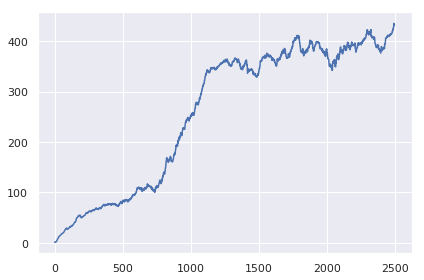

In [6]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./sac_breakout_result.gif', writer='imagemagick', fps=30)

/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/kaist_mlilab/gym/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total Reward : 383.00


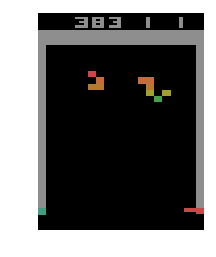

In [8]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
frames = []
done_stack = 0

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a = sac.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_stack += 1
        if done_stack == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./sac_breakout_result.gif "segment")